# My TTN library
In this notebook I try to develop my personal library to handle TTNs, their definition, properties, automatic contraction and training.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import torch
import numpy as np
import pandas as pd
import arff
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from typing import Sequence, ValuesView
from tqdm import tqdm, trange
from string import ascii_letters
from timeit import timeit
from datetime import datetime

from ttn_torch import TIndex, TTNIndex, TTN, TTNModel, check_correct_init
from algebra import contract_up
from utils import *
from torchinfo import summary

FONTSIZE = 14

## TTN with automatic contractions
Try to develop methods to do automatic contractions, also based on the network structure (separability of states)
### Network description

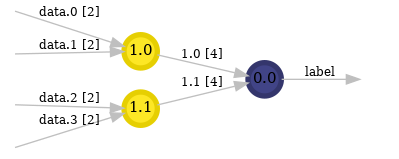

In [4]:
DEVICE = 'cuda'
DTYPE = torch.double
N_FEAT = 4
ttn = TTN(N_FEAT, bond_dim=8, n_labels=2, device=DEVICE, dtype=DTYPE)
ttn.draw()

### Basic operations
General purpose contraction, not optimized

In [9]:
def contract(
        tensors : Sequence[torch.Tensor] | ValuesView[torch.Tensor], 
        tindices: Sequence[TTNIndex | TIndex], 
        keep    : Sequence[str] | None=None, 
        outname : str | None=None
):
    """
    Contract two tensors along the matching TIndices in indices, except for the indices in keep.
    """
    if len(tindices) != len(tensors):
        raise ValueError(f"Expected tensors and tindices to have same lenght, got {len(tensors)} and {len(tindices)}")

    if keep is None:
        keep = []
    elif isinstance(keep, str):
        keep = [keep]
    elif not isinstance(keep, Sequence):
        raise TypeError(f"Expected keep to be None, str or Sequence, got {type(keep)}")

    keep = list(keep)
    unique_inds, counts = np.unique(np.concatenate([tindex.indices for tindex in tindices]), return_counts=True)
    if np.any(np.isin(keep, unique_inds, invert=True)):
        raise ValueError(f"keep contains indices that are not in tindices: {np.asarray(keep)[np.where(np.isin(keep, unique_inds, invert=True))[0]]}")
    if len(unique_inds) > len(ascii_letters):
        raise ValueError(f"Too many indices to contract: {len(unique_inds)} > {len(ascii_letters)}")

    # find output indices (all indices that are not contracted or kept)
    output_inds = unique_inds[np.isin(unique_inds, keep) | (counts == 1)]
    
    # map indices to letters
    idx_to_char_map = {tind: ascii_letters[i] for i, tind in enumerate(unique_inds)}
    
    # contraction strings
    ## tensor indices
    tindices_str = ["..."+"".join([idx_to_char_map[i] for i in tindex.indices]) for tindex in tindices] # the ellipsis is for batch dimension
    ## output indices
    outinds_str = "..."+"".join([idx_to_char_map[i] for i in output_inds])

    #print(tindices_str,'\n' ,outinds_str)
    # contract
    C = torch.einsum(f"{','.join(tindices_str)}->{outinds_str}", *tensors)

    return C, TIndex(f"{min(tindices)}" if outname is None else outname, output_inds)

    

Let's exploit the TTN topology to optimize contractions, i.e. make them go from bottom to top

In [10]:
def contract_up_einsum(tensor: torch.Tensor, data_tensors: Sequence[torch.Tensor]):
    # this function is the fundamental block for TTN contractions:
    # it takes a ttn tensor and two data vectors and contracts them to a new vector

    return torch.einsum('bi,ijk,bj->bk', data_tensors[0], tensor, data_tensors[1])

### Tests

In [11]:
data = torch.rand(N_FEAT, 10, 2, dtype=DTYPE, device=DEVICE).unbind(0)
data_indices = [TIndex(f"{ttn.n_layers}.{i}", [f"data.{i}"]) for i in range(N_FEAT)]

time1 = timeit(lambda: contract_up(ttn.tensors[-1], data[:2]), number=10000)
time2 = timeit(lambda: contract((ttn.tensors[-1],) + data[:2], [ttn.indices[-1]]+data_indices[:2]), number=10000)
time3 = timeit(lambda: contract_up_einsum(ttn.tensors[-1], data[:2]), number=10000)
time1, time2, time3

(0.42125636897981167, 4.402739965997171, 2.430211186001543)

In [12]:
data = torch.rand(N_FEAT, 64, 2, dtype=DTYPE, device=DEVICE).unbind(0)
data_indices = [TIndex(f"data.{i}", [f"data.{i}"]) for i in range(N_FEAT)]
i=1
time1 = timeit(lambda: ttn._propagate_data_through_branch_(dict(zip(data_indices, data)), ttn.get_branch('1.0')), number=100)
time2 = timeit(lambda: ttn._propagate_data_through_branch_(dict(zip(data_indices, data)), ttn.get_branch('1.0'), keep=True), number=100)
time3 = timeit(lambda: contract(list(ttn.get_branch(f'1.{i}').values()) + list(data[16*i:16*(i+1)]), list(ttn.get_branch(f'1.{i}').keys())+data_indices[16*i:16*(i+1)]), number=100)
print(time1, time2, time3)

0.01044276900938712 0.006214366003405303 0.014277718000812456


TEST the contraction scheme by a synthetic dataset and the TTN initialized to identities

In [13]:
def generate_i_state(n_sites, i, dtype=torch.double):
    """
    Generates a separable state wich would be represented 
    as a vector with 1 at i-th position in the full form.
    """
    sites = []
    bin_str = f'{i:b}'
    bin_str = '0'*(n_sites-len(bin_str)) + bin_str
    for char in bin_str:
        if char == '0':
            sites.append(torch.as_tensor([1.0, 0.0], dtype=dtype))
        else:
            sites.append(torch.as_tensor([0.0, 1.0], dtype=dtype))
 
    state = torch.stack(sites)

    return state


# create general purpose identity tensor
# this is a 3d tensor with 1 on the diagonal
ID = torch.zeros([4, 4, 4], dtype=DTYPE)
for i in range(ID.shape[0]):
    ID[i, i, i] = 1.0
# create data
# you can choose from different states
I = 0 # position of 1 in the resulting state (starting from 0)
test_states = {'up': [1, 0], 'down': [0, 1], 'plus': [1/(2**0.5), 1/(2**0.5)], 'minus': [1/(2**0.5), -1/(2**0.5)], 'i': generate_i_state(N_FEAT, I)}
data = torch.expand_copy(torch.as_tensor(test_states['i'], dtype=DTYPE), [64, N_FEAT, 2])

# transform to data dictionary to pass to _propagate_data_through_branch_
data_dict = {TIndex(f"data.{i}", [f"data.{i}"]): datum for i, datum in enumerate(data.unbind(1))}
# set TTN tensors to identity
ttn.tensors = [torch.eye(tensor.shape[0]**2, dtype=DTYPE).reshape(*tensor.shape[:2], -1)[:,:,:tensor.shape[-1]] for tensor in ttn.tensors] #[ID[:tensor.shape[0], :tensor.shape[1], :tensor.shape[2]] for tensor in ttn.tensors]
# contract
pbar = tqdm(total=len(ttn.tensors), desc='ttn test', position=0)
result = ttn._propagate_data_through_branch_(data_dict, ttn.get_branch('0.0'), keep=True, pbar=pbar)['0.0']
pbar.close()
result[0]

ttn test: 100%|██████████| 3/3 [00:00<00:00, 29.90it/s, contracted 0.0] 


tensor([1., 0.], dtype=torch.float64)

## Torch Model

### Test the model

In [74]:
h = 2
features = h**2
BATCH_SIZE = 32
DATASET = 'titanic'
MAPPING = 'poly'
MAP_DIM = 2

if DATASET == 'mnist':
    train_dl, test_dl, train_visual = get_mnist_data_loaders(h, batch_size=BATCH_SIZE)
elif DATASET == 'stripe':
    train_dl, test_dl, features = get_stripeimage_data_loaders(4, h, batch_size=BATCH_SIZE)
elif DATASET == 'iris':
    # worst performance with iris-versicolor and iris-virginica
    train_dl, test_dl, features = get_iris_data_loaders(batch_size=BATCH_SIZE, sel_labels=['Iris-virginica', 'Iris-versicolor', 'Iris-setosa'])
elif DATASET == 'higgs':
    train_dl, test_dl, features = get_higgs_data_loaders(batch_size=BATCH_SIZE)
elif DATASET == 'titanic':
    train_dl, test_dl, features = get_titanic_data_loaders(batch_size=BATCH_SIZE, scale=(0, 1), mapping=MAPPING, dim=MAP_DIM)   # scales different from (0, 1) are reasonable only in the poly mapping

In [63]:
def loss(labels, output: torch.Tensor, weights, l=0.1):
    loss_value = 0.
    # regularization
    if l > 0.:
        norm = 0
        for tensor in weights:
            norm += torch.norm(tensor)
        norm /= len(weights)
        loss_value += l*(norm-1.)**2

    # loss based on output dimension
    if len(output.squeeze().shape) > 1:
        loss_value += torch.mean(torch.sum((output.squeeze() - labels)**2), -1)/2 
    else:
        loss_value += torch.mean((output.squeeze() - labels)**2)/2
    
    return loss_value

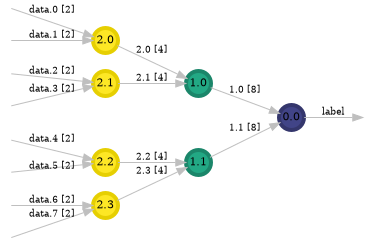

In [75]:
DEVICE = 'cuda'
BOND_DIM = 8
DTYPE = torch.double
N_LABELS = 1
MODEL_DIR = 'titanic_models'

model = TTNModel(features, n_phys=MAP_DIM, bond_dim=BOND_DIM, n_labels=N_LABELS, device=DEVICE, dtype=DTYPE)
model.draw()

In [76]:
INIT_EPOCHS = 20

model.initialize(True, train_dl, loss, INIT_EPOCHS)

ttn supervised init:   0%|          | 0/22 [00:13<?, ?it/s, doing epoch 20/20]


In [77]:
print(check_correct_init(model))
summary(model, input_size=(BATCH_SIZE, features, MAP_DIM), dtypes=[DTYPE], device=DEVICE)

(True, 0)


Layer (type:depth-idx)                   Output Shape              Param #
TTNModel                                 [32, 1]                   384
Total params: 384
Trainable params: 384
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [78]:
LR = 0.02
EPOCHS = 100
LAMBDA = 0.1
SCHEDULER_STEPS = 5


model.train()
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
schedulers = [torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9, last_epoch=-1, verbose=False), torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 10, eta_min=1e-5)]
scheduler = schedulers[0]

In [79]:

tot_loss_history = []
now = datetime.now()
for epoch in trange(EPOCHS, desc='epochs', position=0):
    loss_history = train_one_epoch(model, DEVICE, train_dl, lambda *x: loss(*x, l=LAMBDA), optimizer)
    tot_loss_history += loss_history
    if epoch % SCHEDULER_STEPS == SCHEDULER_STEPS-1:
        scheduler.step()

    
loss_history = np.array(tot_loss_history)

epochs:   0%|          | 0/100 [00:00<?, ?it/s]

epochs: 100%|██████████| 100/100 [01:47<00:00,  1.08s/it]


In [80]:
accuracy(model, DEVICE, train_dl, test_dl, DTYPE)

train:   0%|          | 0/22 [00:00<?, ?it/s]

train: 100%|██████████| 22/22 [00:00<00:00, 41.70it/s]


(0.7852941176470588, 0.8117647058823529)

In [81]:
torch.save(model.state_dict, MODEL_DIR + f'/trainedmodel_{DATASET}_bd{BOND_DIM}_{now.strftime("%Y%m%d-%H%M%S")}.dict')
np.save(MODEL_DIR + f'/loss_history_{now.strftime("%Y%m%d-%H%M%S")}.npy', loss_history)

### Plots

0.07544543576731728


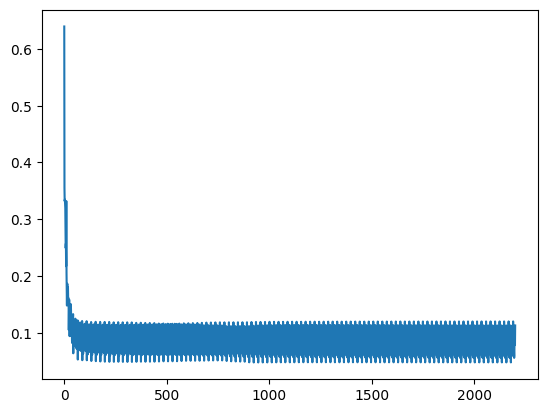

In [82]:
plt.plot(range(len(loss_history)), loss_history)
#plt.ylim(0, 2)
print(np.mean(loss_history[-10:]))

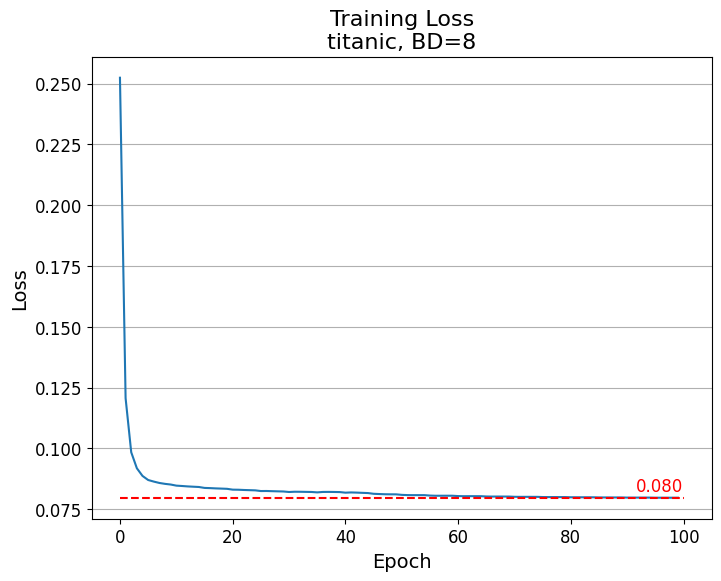

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot([loss_history[i*len(train_dl):((i+1)*len(train_dl) if i<EPOCHS-1 else None)].mean() for i in range(EPOCHS)])
#ax.set_ylim(0, 0.3)
ax.set_xlabel('Epoch', fontsize=FONTSIZE)
ax.set_ylabel('Loss', fontsize=FONTSIZE)
ax.set_title(F'Training Loss\n{DATASET}, BD={BOND_DIM}', fontsize=FONTSIZE+2)
ax.tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
ax.grid(axis='y')

ax.hlines(loss_history[(EPOCHS-1)*len(train_dl):].mean(), 0, EPOCHS, colors='r', linestyles='dashed')
ax.text(EPOCHS, loss_history[(EPOCHS-1)*len(train_dl):].mean()+0.001, f'{loss_history[(EPOCHS-1)*len(train_dl):].mean():.3f}', fontsize=FONTSIZE-2, color='r', verticalalignment='bottom', horizontalalignment='right')
fig.savefig(MODEL_DIR + f'/loss_history_{DATASET}_bd{BOND_DIM}_{now.strftime("%Y%m%d-%H%M%S")}.png')

In [84]:
def get_predictions(model, device, dl, dtype=torch.complex128, disable_pbar=False):

    model.eval()
    model.to(device)
    predictions = []
    with torch.no_grad():
        for data in tqdm(dl, total=len(dl), position=0, desc='test', disable=disable_pbar):
            images, labels = data
            images, labels = images.to(device, dtype=dtype).squeeze(), labels.to(device)
            outputs = model(images)
            probs = torch.real(torch.pow(outputs, 2))
            #probs = probs / torch.sum(probs)
            predictions.append(probs.squeeze().detach().cpu())

    return torch.concat(predictions, dim=0)


def get_output(model, device, dl, dtype=torch.complex128, disable_pbar=False):

    model.eval()
    model.to(device)
    outputs = []
    with torch.no_grad():
        for data in tqdm(dl, total=len(dl), position=0, desc='test', disable=disable_pbar):
            images, labels = data
            images, labels = images.to(device, dtype=dtype).squeeze(), labels.to(device)
            outputs.append(model(images).squeeze().detach().cpu())

    return torch.concat(outputs, dim=0)

test:   0%|          | 0/22 [00:00<?, ?it/s]

test: 100%|██████████| 6/6 [00:00<00:00, 838.22it/s]


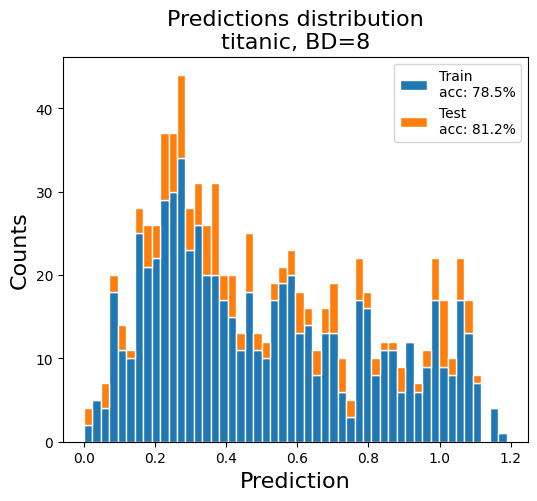

In [85]:
import sys
sys.path.insert(0, '../')
from images.plot_utils import plot_predictions

train_pred = get_predictions(model, DEVICE, train_dl, DTYPE)
test_pred = get_predictions(model, DEVICE, test_dl, DTYPE)

fig, ax = plot_predictions(train_pred, test_pred, N_LABELS)

train_acc, test_acc = accuracy(model, DEVICE, train_dl, test_dl, DTYPE, disable_pbar=True)

ax.legend([f'Train\nacc: {train_acc:.1%}', f'Test\nacc: {test_acc:.1%}'])
ax.set_title(f'Predictions distribution\n{DATASET}, BD={BOND_DIM}', fontsize=FONTSIZE+2)

fig.savefig(MODEL_DIR + f'/predictions_dist_{DATASET}_bd{BOND_DIM}_{now.strftime("%Y%m%d-%H%M%S")}.png')

In [86]:
# save model output
train_out = get_output(model, DEVICE, train_dl, DTYPE)
test_out = get_output(model, DEVICE, test_dl, DTYPE)
np.save(MODEL_DIR + f'/train_out_{now.strftime("%Y%m%d-%H%M%S")}.npy', train_out)
np.save(MODEL_DIR + f'/test_out_{now.strftime("%Y%m%d-%H%M%S")}.npy', test_out)

test:   0%|          | 0/22 [00:00<?, ?it/s]

test: 100%|██████████| 6/6 [00:00<00:00, 754.28it/s]


### ROC

ROC AUC Score: 0.86


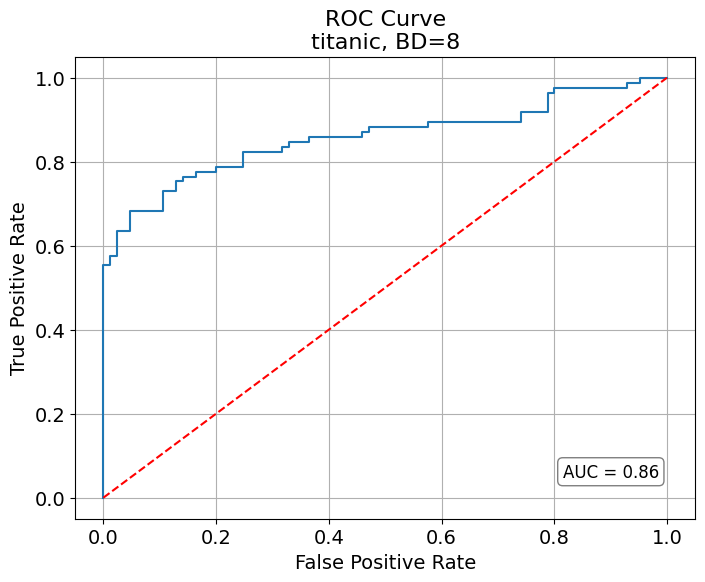

In [87]:
y_true = torch.cat([y for _, y in test_dl], dim=0).numpy()

fpr, tpr, thresholds = roc_curve(y_true, test_pred)
auc = roc_auc_score(y_true, test_pred)

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'r--')
ax.set_xlabel('False Positive Rate', fontsize=FONTSIZE)
ax.set_ylabel('True Positive Rate', fontsize=FONTSIZE)
ax.set_title(f'ROC Curve\n{DATASET}, BD={BOND_DIM}', fontsize=FONTSIZE+2)
ax.tick_params(axis='both', which='major', labelsize=FONTSIZE)
ax.text(0.815, 0.05, f'AUC = {auc:.2f}', fontsize=FONTSIZE-2, bbox=props)
ax.grid()
fig.savefig(MODEL_DIR + f'/roc_curve_{DATASET}_bd{BOND_DIM}_{now.strftime("%Y%m%d-%H%M%S")}.png')

print('ROC AUC Score:', round(roc_auc_score(y_true, test_pred), 2))

In [88]:
best_10 = np.argsort(tpr-fpr)[::-1][:10]

print(tpr[best_10], fpr[best_10], sep='\n')
thresholds[best_10]

[0.68235294 0.72941176 0.75294118 0.76470588 0.75294118 0.77647059
 0.63529412 0.72941176 0.76470588 0.78823529]
[0.04705882 0.10588235 0.12941176 0.14117647 0.14117647 0.16470588
 0.02352941 0.12941176 0.16470588 0.2       ]


array([0.63266219, 0.56481833, 0.51585048, 0.49551418, 0.49971137,
       0.46754099, 0.67817678, 0.54429775, 0.46983427, 0.45967951])

In [89]:
#save model weights
np.savez(MODEL_DIR + f'/weights_{now.strftime("%Y%m%d-%H%M%S")}.npz', **{key.name : value.cpu().detach() for key, value in model._TTN__tensor_map.items()})

## Get weights distribution

In [162]:
def get_weights_population(n, dataloader, disable_pbar=False, **kws):
    weights_ls = []
    DEVICE = 'cuda'
    BATCH_SIZE = 64
    DTYPE = torch.double
    INIT_EPOCHS = 5
    LR = 0.05
    EPOCHS = 80
    SCHEDULER_STEPS = 4
    train_dl, test_dl, features = dataloader(batch_size=BATCH_SIZE, **kws)

    label_shape = next(iter(train_dl))[1].shape
    N_LABELS = 1 if len(label_shape) == 1 else label_shape[1]
    
    pbar = tqdm(total=n*EPOCHS*len(train_dl), position=0, desc='weights population', leave=True, disable=disable_pbar)
    for _ in range(n):        
        model = TTNModel(features, bond_dim=BOND_DIM, n_labels=N_LABELS, device=DEVICE, dtype=DTYPE)
        model.initialize(True, train_dl, loss, INIT_EPOCHS, disable_pbar=True)
        model.train()
        model.to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
        schedulers = [torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9, last_epoch=-1, verbose=False), torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 10, eta_min=1e-5)]
        scheduler = schedulers[0]
        tot_loss_history = []
        for epoch in range(EPOCHS):
            loss_history = train_one_epoch(model, DEVICE, train_dl, loss, optimizer, pbar=pbar, disable_pbar=disable_pbar)
            tot_loss_history += loss_history
            if epoch % SCHEDULER_STEPS == SCHEDULER_STEPS-1:
                scheduler.step()

        loss_history = np.array(tot_loss_history)
        print('Accuracy on train and test set:', accuracy(model, DEVICE, train_dl, test_dl, DTYPE, disable_pbar=True))

        weights = [tensor.detach().cpu().flatten() for tensor in model.tensors]
        weights_ls.append(torch.concat(weights, dim=0))
        train_dl, test_dl, h = dataloader(batch_size=BATCH_SIZE, **kws)
    return torch.stack(weights_ls)

In [163]:
BOND_DIM = 10
weights = get_weights_population(5, get_titanic_data_loaders)

weights population:  20%|██        | 1120/5600 [00:45<02:50, 26.26it/s, current loss=0.0179, batches 0-10 loss=0.0884, epoch mean loss=0.0826]

Accuracy on train and test set: (0.7709832134292566, 0.7751196172248804)


weights population:  40%|████      | 2240/5600 [01:31<02:07, 26.43it/s, current loss=0.00987, batches 0-10 loss=0.0898, epoch mean loss=0.0837]

Accuracy on train and test set: (0.762589928057554, 0.8038277511961722)


weights population:  60%|██████    | 3360/5600 [02:17<01:24, 26.48it/s, current loss=0.0152, batches 0-10 loss=0.0905, epoch mean loss=0.0824] 

Accuracy on train and test set: (0.7997601918465228, 0.8038277511961722)


weights population:  80%|████████  | 4480/5600 [03:03<00:42, 26.64it/s, current loss=0.0278, batches 0-10 loss=0.0893, epoch mean loss=0.0857]

Accuracy on train and test set: (0.7805755395683454, 0.7751196172248804)


weights population: 100%|██████████| 5600/5600 [03:50<00:00, 24.31it/s, current loss=0.00934, batches 0-10 loss=0.0808, epoch mean loss=0.08]  

Accuracy on train and test set: (0.7889688249400479, 0.7464114832535885)


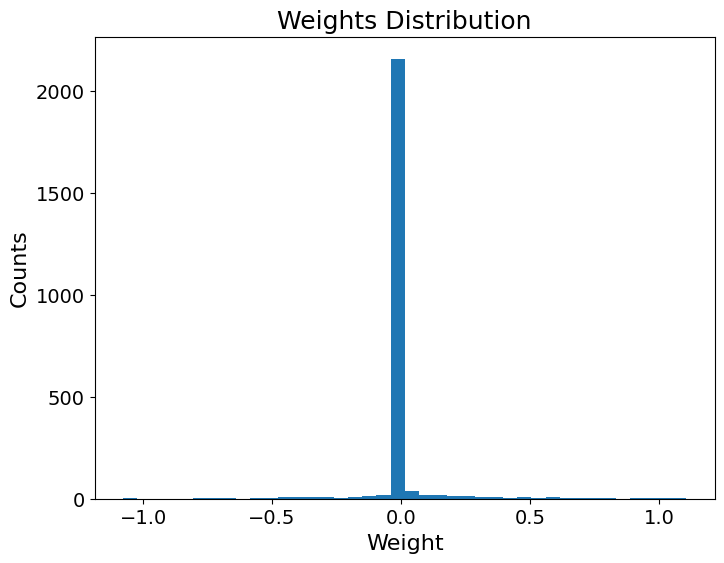

In [177]:
weights_plt = weights.flatten().numpy()
np.save(f'models/weights_{BOND_DIM}_{now.strftime("%Y%m%d-%H%M%S")}.npy', weights.numpy())
FS = 16
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(weights_plt, bins=40)
ax.set_xlabel('Weight', fontsize=FS)
ax.set_ylabel('Counts', fontsize=FS)
ax.set_title('Weights Distribution', fontsize=FS+2)
ax.tick_params(axis='both', which='major', labelsize=FS-2)
#ax.set_yticklabels(ax.get_yticks(), fontsize=FS-2)

fig.savefig(f'models/weight_distribution_{BOND_DIM}_{now.strftime("%Y%m%d-%H%M%S")}.svg')

In [180]:
print('min', np.abs(weights.numpy()).min(axis=1).mean(), 'max', np.abs(weights.numpy()).max(axis=1).mean(), sep='\n')

min
2.1533213614432906e-20
max
1.068453143754883


# Quantized model

In [249]:
from qtorch import FixedPoint, FloatingPoint
from qtorch.quant import Quantizer, fixed_point_quantize
from qtorch.optim import OptimLP

wl = 16
fl = 14

forward_num = FixedPoint(wl=wl, fl=fl)
backward_num = FixedPoint(wl=wl, fl=fl)

# Create a quantizer
Q = Quantizer(forward_number=forward_num, backward_number=backward_num,
              forward_rounding="nearest", backward_rounding="nearest")

MODEL_DIR = 'qmodels'

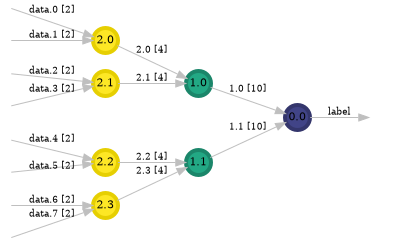

In [322]:
DEVICE = 'cuda'
BOND_DIM = 10
DTYPE = torch.float        # we use float for the quantization, as qtorch does not support double
N_LABELS = 1

qmodel = TTNModel(features, bond_dim=BOND_DIM, n_labels=N_LABELS, device=DEVICE, dtype=DTYPE, quantizer=Q)
qmodel.draw()

In [323]:
INIT_EPOCHS = 15

qmodel.initialize(True, train_dl, loss, INIT_EPOCHS)
summary(qmodel, input_size=(BATCH_SIZE, features, 2), dtypes=[DTYPE], device=DEVICE)

ttn supervised init:   0%|          | 0/6 [00:08<?, ?it/s, doing epoch 15/15]


Layer (type:depth-idx)                   Output Shape              Param #
TTNModel                                 [128, 1]                  484
├─Quantizer: 1-1                         [2, 2, 4]                 --
├─Quantizer: 1-2                         [128, 2]                  --
├─Quantizer: 1-3                         [128, 8]                  --
├─Quantizer: 1-4                         [128, 2]                  --
├─Quantizer: 1-5                         [128, 1, 4]               --
├─Quantizer: 1-6                         [2, 2, 4]                 --
├─Quantizer: 1-7                         [128, 2]                  --
├─Quantizer: 1-8                         [128, 8]                  --
├─Quantizer: 1-9                         [128, 2]                  --
├─Quantizer: 1-10                        [128, 1, 4]               --
├─Quantizer: 1-11                        [2, 2, 4]                 --
├─Quantizer: 1-12                        [128, 2]                  --
├─Quantizer: 1

In [324]:
LR = 0.02
EPOCHS = 100
LAMBDA = 0.1
SCHEDULER_STEPS = 10


qmodel.train()
qmodel.to(DEVICE)
optimizer = torch.optim.Adam(qmodel.parameters(), lr=LR)
# define custom quantization functions for different numbers
weight_quant = lambda x : fixed_point_quantize(x, wl, fl, rounding="nearest")
# turn your optimizer into a low precision optimizer
optimizer = OptimLP(optimizer,
                    weight_quant=weight_quant)
schedulers = [torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9, last_epoch=-1, verbose=False), torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 10, eta_min=1e-5)]
scheduler = schedulers[0]

In [325]:

tot_loss_history = []
now = datetime.now()
for epoch in trange(EPOCHS, desc='epochs', position=0):
    loss_history = train_one_epoch(qmodel, DEVICE, train_dl, lambda *x: loss(*x, l=LAMBDA), optimizer)
    tot_loss_history += loss_history
    if epoch % SCHEDULER_STEPS == SCHEDULER_STEPS-1:
        scheduler.step()

    
loss_history = np.array(tot_loss_history)

epochs:   0%|          | 0/100 [00:00<?, ?it/s]

epochs: 100%|██████████| 100/100 [01:42<00:00,  1.03s/it]


In [326]:
accuracy(qmodel, DEVICE, train_dl, test_dl, DTYPE)

train:   0%|          | 0/6 [00:00<?, ?it/s]

train: 100%|██████████| 6/6 [00:00<00:00, 10.39it/s]


(0.7485294117647059, 0.7647058823529411)

In [327]:
torch.save(model.state_dict, MODEL_DIR + f'/trainedmodel_{DATASET}_bd{BOND_DIM}_{now.strftime("%Y%m%d-%H%M%S")}.dict')
np.savez(MODEL_DIR + f'/modelweights_{DATASET}_bd{BOND_DIM}_{now.strftime("%Y%m%d-%H%M%S")}.npz', **{key.name: value.cpu().detach() for key, value in qmodel._TTN__tensor_map.items()})

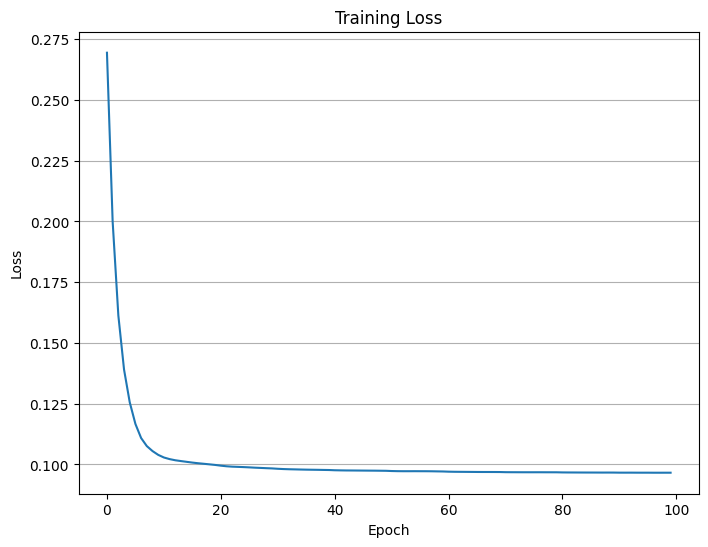

In [328]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot([loss_history[i*len(train_dl):((i+1)*len(train_dl) if i<EPOCHS-1 else None)].mean() for i in range(EPOCHS)])
#ax.set_ylim(0, 0.3)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Loss')
ax.grid(axis='y')

fig.savefig(MODEL_DIR + f'/loss_history_{now.strftime("%Y%m%d-%H%M%S")}.png')

test:   0%|          | 0/6 [00:00<?, ?it/s]

test: 100%|██████████| 2/2 [00:00<00:00, 237.58it/s]


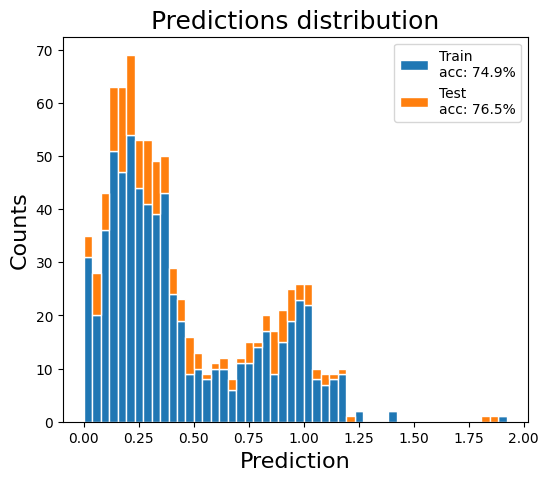

In [329]:
train_pred = get_predictions(qmodel, DEVICE, train_dl, DTYPE)
test_pred = get_predictions(qmodel, DEVICE, test_dl, DTYPE)

fig, ax = plot_predictions(train_pred, test_pred, N_LABELS)

train_acc, test_acc = accuracy(qmodel, DEVICE, train_dl, test_dl, DTYPE, disable_pbar=True)

ax.legend([f'Train\nacc: {train_acc:.1%}', f'Test\nacc: {test_acc:.1%}'])

fig.savefig(MODEL_DIR + f'/predictions_dist_{now.strftime("%Y%m%d-%H%M%S")}.png')

ROC AUC Score: 0.81


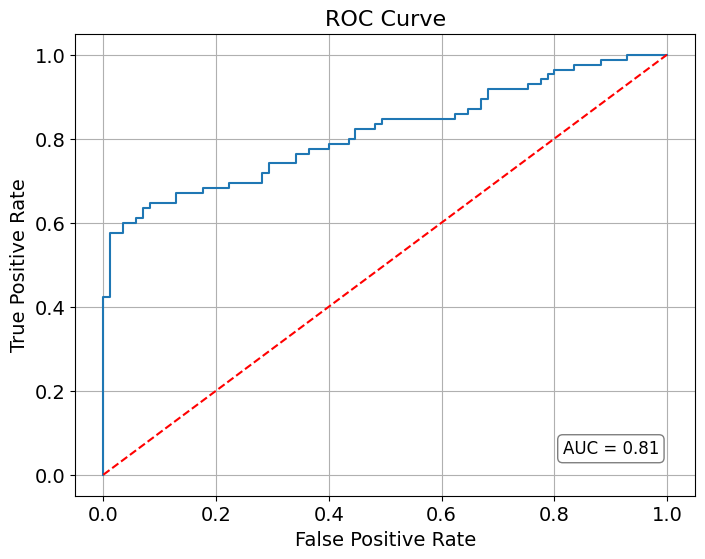

In [330]:
y_true = torch.cat([y for _, y in test_dl], dim=0).numpy()

fpr, tpr, thresholds = roc_curve(y_true, test_pred)
auc = roc_auc_score(y_true, test_pred)

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'r--')
ax.set_xlabel('False Positive Rate', fontsize=FONTSIZE)
ax.set_ylabel('True Positive Rate', fontsize=FONTSIZE)
ax.set_title('ROC Curve', fontsize=FONTSIZE+2)
ax.tick_params(axis='both', which='major', labelsize=FONTSIZE)
ax.text(0.815, 0.05, f'AUC = {auc:.2f}', fontsize=FONTSIZE-2, bbox=props)
ax.grid()
fig.savefig(MODEL_DIR + f'/roc_curve_{now.strftime("%Y%m%d-%H%M%S")}.png')

print('ROC AUC Score:', round(roc_auc_score(y_true, test_pred), 2))

# Trash

In [23]:
torch.load('data/grid_search/model_8_4_16_False_torch.float64.pth')['_TTN__tensors.0']

tensor([[[-3.7677e-04],
         [-1.5435e-02],
         [-1.8145e-04],
         [-6.1096e-04]],

        [[-7.9009e-04],
         [ 1.0263e+00],
         [ 5.1388e-05],
         [ 1.5473e-04]],

        [[ 7.0854e-04],
         [-3.7704e-03],
         [-9.0056e-05],
         [-2.6149e-04]],

        [[ 1.3896e-06],
         [ 3.0381e-06],
         [-4.7425e-08],
         [ 3.6490e-08]]], device='cuda:0', dtype=torch.float64)

In [24]:
data_arff = arff.load(open('../data/titanic/titanic.arff', 'r'))
dataframe = pd.DataFrame(data_arff['data'])
dataframe.columns = [x[0] for x in data_arff['attributes']]
dataframe.drop(columns=['name', 'cabin', 'body', 'boat', 'home.dest'], inplace=True)
dataframe.dropna(inplace=True)
dataframe.to_csv('../data/titanic/titanic.csv', index=False)
dataframe

,pclass,survived,sex,age,sibsp,parch,ticket,fare,embarked
0,1.0,1,female,29.0000,0.0,0.0,24160,211.3375,S
1,1.0,1,male,0.9167,1.0,2.0,113781,151.5500,S
2,1.0,0,female,2.0000,1.0,2.0,113781,151.5500,S
3,1.0,0,male,30.0000,1.0,2.0,113781,151.5500,S
4,1.0,0,female,25.0000,1.0,2.0,113781,151.5500,S
...,...,...,...,...,...,...,...,...,...
1301,3.0,0,male,45.5000,0.0,0.0,2628,7.2250,C
1304,3.0,0,female,14.5000,1.0,0.0,2665,14.4542,C
1306,3.0,0,male,26.5000,0.0,0.0,2656,7.2250,C
1307,3.0,0,male,27.0000,0.0,0.0,2670,7.2250,C


In [9]:
path = '../data'
train = torch.tensor(np.load(path + '/Higgs/higgs_train.npy'))
permutation = torch.randperm(train.shape[1])
train[:, permutation]

tensor([[0.0904, 0.0914, 0.0542,  ..., 0.0864, 0.1605, 0.0784],
        [0.0696, 0.0101, 0.2556,  ..., 0.0958, 0.1628, 0.0855],
        [0.1086, 0.0571, 0.0760,  ..., 0.0915, 0.1628, 0.0884],
        ...,
        [0.0738, 0.0417, 0.0953,  ..., 0.0465, 0.1630, 0.0200],
        [0.1266, 0.0523, 0.1389,  ..., 0.0470, 0.1904, 0.0359],
        [0.1017, 0.1164, 0.0242,  ..., 0.1215, 0.1623, 0.0765]])

In [21]:
torch.randperm(train.shape[1]).tolist()

[2, 3, 4, 6, 5, 7, 0, 1]

In [17]:
[np.random.permutation(4) for _ in range(5)]

[array([0, 1, 3, 2]),
 array([1, 2, 0, 3]),
 array([2, 3, 0, 1]),
 array([1, 2, 3, 0]),
 array([0, 1, 3, 2])]